In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.getcwd()

import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, fbeta_score

### Sommaire

Donc résumé de la nouvelle strat :

1- creation fonction pour transormDF(df_origin) => (df_clean) : ajouter -scaler dans le nom des variable à scale)

2- vérifier et exclure variable corrélées ( bonus : + tentative cluster auto) -OUPS

3- pipeline : 
        A/Split
        B/transformDF
        C/model = dummy + regression + xgbClassifier ( comparer SMOTE / class_weight)
        D/synthes cv

4- Xgb explore :
        A/ seuil f1
        B/ shap + feature importance
        C/ tentaive de light_model
        D/ etude des resultats

5- Conclusion Client :
        -la meme


6- Piste améliorations
        



In [2]:


df_eval = pd.read_csv('extrait_eval.csv')
df_sirh = pd.read_csv('extrait_sirh.csv')
df_sondage = pd.read_csv('extrait_sondage.csv')


df1 = df_eval.copy()

  # Celui avec id_employee
df2 = df_sirh.copy()  # Sans id
df3 = df_sondage.copy()  # Sans id

# Vérifie que les index sont bien alignés
assert df1.shape[0] == df2.shape[0] == df3.shape[0]

# Fusionner horizontalement
df_merged = pd.concat([df1, df2, df3], axis=1)

# mais il faut vérifier que lon peut bien utiliser l'index ou les num d'eval comme un id. 

# Sélection des colonnes numériques
df_num = df_merged.select_dtypes(include='number').copy()

# Sélection des colonnes non numériques (catégorielles)
df_cat = df_merged.select_dtypes(exclude='number').copy()

df_num = df_num.drop(['id_employee', 'code_sondage', 'nombre_heures_travailless', 'nombre_employee_sous_responsabilite'], axis=1) # id + id + toujours = à 80 + nb employé tjr =1 
df_cat = df_cat.drop(['eval_number', 'ayant_enfants'], axis=1)  # id + toujours = à 1

df_merged = pd.concat([df_num, df_cat], axis=1)


#df_merged.info()

### Les transformations

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold
import category_encoders as ce

def transform_df_encoder(x, y_target='a_quitte_l_entreprise'):
    df = x.copy()

    y = df['a_quitte_l_entreprise']

    ##
    ## Séparer les blocs
    ##

    df_num = df.select_dtypes(include='number').copy()
    df_cat = df.select_dtypes(exclude='number').copy()

    ##
    ## Définir variables par type
    ##

    # Nominales ➜ OneHotEncoder
    ohe_cols = ['heure_supplementaires', 'genre', 'domaine_etude', 'departement']  

    # Ordinales ➜ OrdinalEncoder
    ord_cols = [
        'augementation_salaire_precedente',
        'frequence_deplacement',
        'statut_marital'
    ]

    ord_num_cols = [
        'satisfaction_employee_environnement',
        'note_evaluation_precedente',
        'satisfaction_employee_nature_travail',
        'satisfaction_employee_equipe',
        'satisfaction_employee_equilibre_pro_perso',
        #'nombre_participation_pee',
        'niveau_education',
        'nb_formations_suivies'
    ]



    

    # TargetEncoder ➜ poste par exemple
    target_cols = ['poste', 'niveau_hierarchique_poste' ]

    ##
    ## Encodage One-Hot
    ##

    ohe = OneHotEncoder(drop='if_binary', sparse_output=False)
    ohe_encoded = ohe.fit_transform(df_cat[ohe_cols])
    ohe_df = pd.DataFrame(ohe_encoded,
                          columns=ohe.get_feature_names_out(ohe_cols),
                          index=df_cat.index)

    ##
    ## Encodage Ordinal   = pour les ord col num il n'y a pas de modif mais pour celles ci il faut les remettre danbs l'ordre logique avant d'encoder
    ##

    # Pour augementation_salaire_precedente : fixer ordre
    order_salary = [
        '11 %', '12 %', '13 %', '14 %', '15 %', '16 %',
        '17 %', '18 %', '19 %', '20 %', '21 %', '22 %',
        '23 %', '24 %', '25 %'
    ]
    df_cat['augementation_salaire_precedente'] = pd.Categorical(
        df_cat['augementation_salaire_precedente'],
        categories=order_salary,
        ordered=True
    )

    # Mapper manuel pour statut_marital
    map_sm = {
        'Célibataire': 3,
        'Marié(e)': 2,
        'Divorcé(e)': 1
    }
    df_cat['statut_marital'] = df_cat['statut_marital'].map(map_sm)

    # Mapper manuel pour frequence_deplacement
    map_freq = {
        'Frequent': 3,
        'Occasionnel': 2,
        'Aucun': 1
    }
    df_cat['frequence_deplacement'] = df_cat['frequence_deplacement'].map(map_freq)

    ord_df = df_cat[ord_cols].copy()
    ord_df['augementation_salaire_precedente'] = df_cat['augementation_salaire_precedente'].cat.codes

    ##
    ## TargetEncoder K-Fold
    ##

    y = df[y_target]
    te = ce.TargetEncoder(cols=target_cols)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Collecte tous les folds dans une liste
    te_folds = []

    for train_idx, valid_idx in kf.split(df):
        te.fit(df.iloc[train_idx][target_cols], y.iloc[train_idx])
        te_transformed = te.transform(df.iloc[valid_idx][target_cols])
        te_transformed.index = valid_idx  # Garder l'index correct
        te_folds.append(te_transformed)

    # Recolle tous les morceaux encodés
    te_df = pd.concat(te_folds).sort_index().add_suffix('_te')

    ##
    ## Continues ➜ transformation log, binning, etc.
    ##

    df_num_clean = df_num.copy()
    df_num_clean = df_num.drop(columns=ord_num_cols).copy()
    

    bins = [-0.1, 2500, 5000, 14000, np.inf]
    df_num_clean['revenu_mensuel'] = pd.cut(df_num['revenu_mensuel'], bins=bins)
    df_num_clean['revenu_mensuel_log'] = np.log1p(df_num['revenu_mensuel'])
    df_num_clean.drop(['revenu_mensuel'], axis=1, inplace=True)

    df_num_clean['nombre_experiences_precedentes'] = np.log1p(df_num_clean['nombre_experiences_precedentes'])
    df_num_clean['annee_experience_totale'] = np.log1p(df_num_clean['annee_experience_totale'])
    df_num_clean['annees_dans_l_entreprise'] = np.log1p(df_num_clean['annees_dans_l_entreprise'])
    df_num_clean['annees_dans_le_poste_actuel'] = np.log1p(df_num_clean['annees_dans_le_poste_actuel'])
    df_num_clean['distance_domicile_travail'] = np.log1p(df_num_clean['distance_domicile_travail'])

    # Retirer colonnes corrélées si besoin
    df_num_clean.drop(['annee_experience_totale', 'annees_dans_l_entreprise'], axis=1, inplace=True)

    ##
    ## Joindre blocs
    ##

    df_all = pd.concat([ohe_df, ord_df, df_num_clean, df[ord_num_cols], te_df], axis=1)

    ##
    ## Feature Engineering custom
    ##

    df_all['ratio_appartenance'] = df['annees_dans_l_entreprise'] / df['annee_experience_totale']
    df_all['interet_long_terme'] = df['nombre_participation_pee'] / df['annees_dans_l_entreprise'].replace(0, np.nan)
    df_all['ratio_poste'] = df['annees_dans_le_poste_actuel'] / df['annees_dans_l_entreprise'].replace(0, np.nan)
    df_all['valeur_formation'] = df['revenu_mensuel'] / df['niveau_education'].replace(0, np.nan)

    df_all['flag_cluster_inertie_2'] = (
        (df_all['revenu_mensuel_log'] > df_all['revenu_mensuel_log'].median()) &
        (df_all['heure_supplementaires_Oui'] == 0)
    ).astype(int)

    df_all.fillna(0, inplace=True)


    df_all.drop(['niveau_hierarchique_poste_te', 'niveau_hierarchique_poste'], axis=1, inplace=True) #bad pearson
    df_all.drop(['departement_Ressources Humaines', 'domaine_etude_Marketing', 'note_evaluation_actuelle', 'domaine_etude_Autre', 'domaine_etude_Ressources Humaines'], axis=1, inplace=True) #bad feature global
    df_all.drop(['annes_sous_responsable_actuel'], axis=1, inplace=True) #bad : analyse finale : produit plus de FN que tout le reste
    
    

    return df_all, y


In [4]:
df_clean, y = transform_df_encoder(df_merged)
df_clean.info()
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   heure_supplementaires_Oui                  1470 non-null   float64
 1   genre_M                                    1470 non-null   float64
 2   domaine_etude_Entrepreunariat              1470 non-null   float64
 3   domaine_etude_Infra & Cloud                1470 non-null   float64
 4   domaine_etude_Transformation Digitale      1470 non-null   float64
 5   departement_Commercial                     1470 non-null   float64
 6   departement_Consulting                     1470 non-null   float64
 7   augementation_salaire_precedente           1470 non-null   int8   
 8   frequence_deplacement                      1470 non-null   int64  
 9   statut_marital                             1470 non-null   int64  
 10  age                     

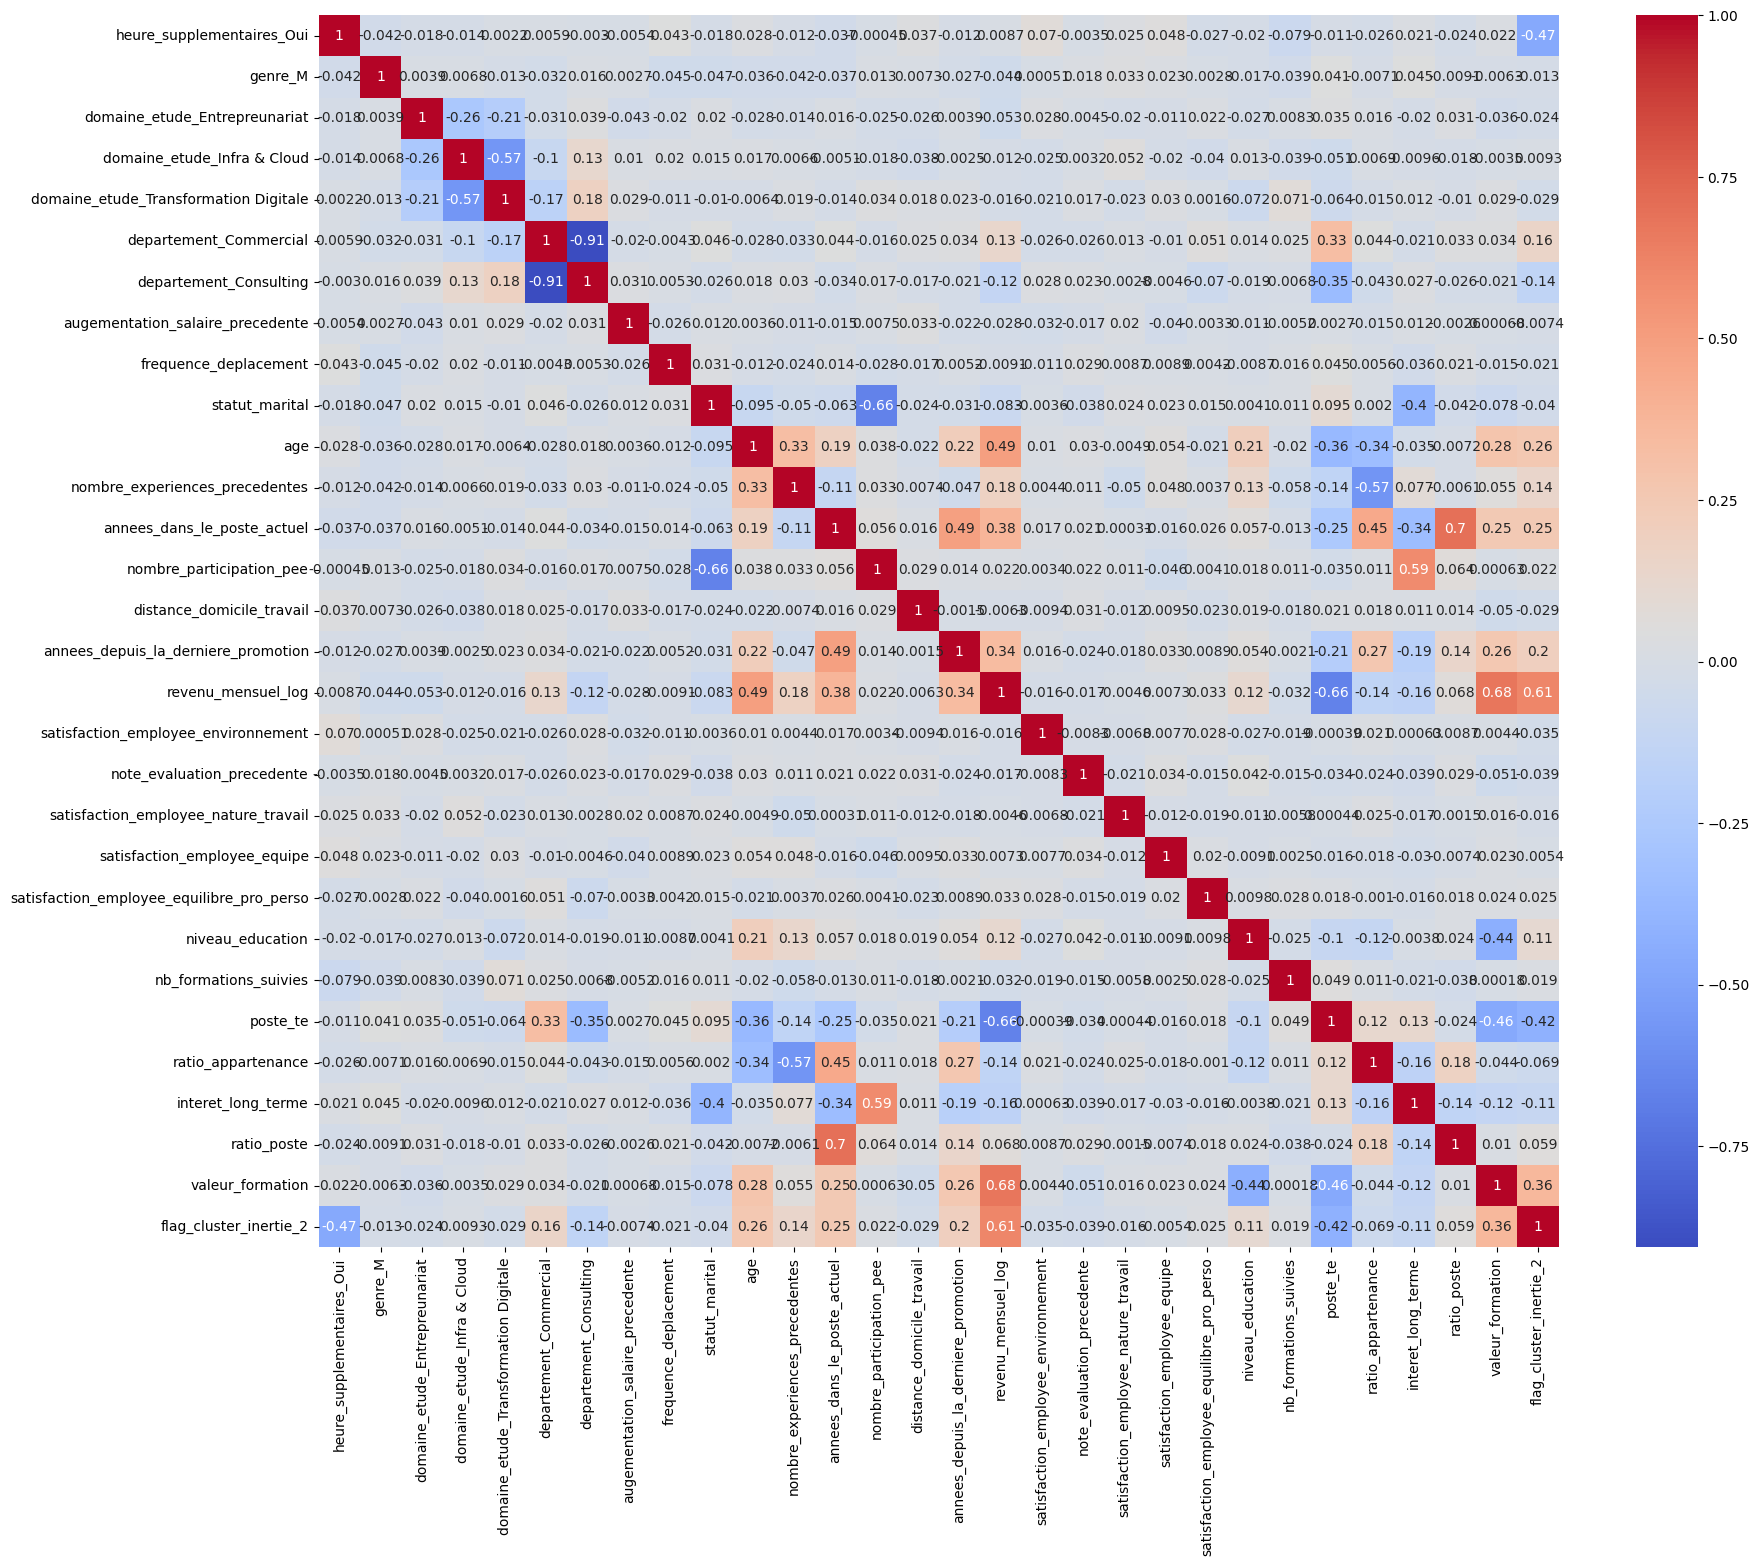

               Variable 1              Variable 2  Correlation
0  departement_Commercial  departement_Consulting    -0.906818
1  departement_Consulting  departement_Commercial    -0.906818


In [5]:
plt.figure(figsize=(20, 16))
corr = df_clean.corr(method='pearson')   ### attention il faut mapper la terget
#corr = df_clean.corr(method='spearmman')   ### REGARDER ACP ou pCA    REGARDER NGBOOST et PGBM
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

high_corr = corr[(np.abs(corr) > 0.7) & (np.abs(corr) < 1.0)]
result = high_corr.stack().reset_index()
result.columns = ['Variable 1', 'Variable 2', 'Correlation']
print(result)

==> on va retirer les variables annees , aussi on pourrait essayer de target encoder niveau hiearchique pour verifier si on fait disparaitre la corrélation.

==> niveau hierarchique te est toujours corélé avec Revenu mesuel : on va le retirer aussi.

==> il nous reste note eval actuel et augmentation salaire  => nopte eval est une ordianal donc plutot une categorielle : les pearson ne fonctionne pas bien et on est juste a 0.377, on va keep.

### Train model

Train: (1029, 30) | Test: (441, 30)

=== Résultats Validation Croisée ===
fit_time: [0.02699947 0.03272605 0.03105021 0.02871466 0.03166366]
score_time: [0.00550199 0.00500607 0.00600839 0.00599599 0.00500464]
test_accuracy: [0.83980583 0.8592233  0.87378641 0.85436893 0.85853659]
train_accuracy: [0.95868773 0.9671932  0.95868773 0.96111786 0.96116505]
test_f1: [0.91008174 0.92054795 0.92857143 0.91712707 0.92098093]
train_f1: [0.97588652 0.98075552 0.97595474 0.97736917 0.97736917]
test_roc_auc: [0.78980557 0.75407252 0.79768786 0.84815321 0.8192389 ]
train_roc_auc: [0.99165305 0.99192547 0.99405034 0.99003421 0.99361283]


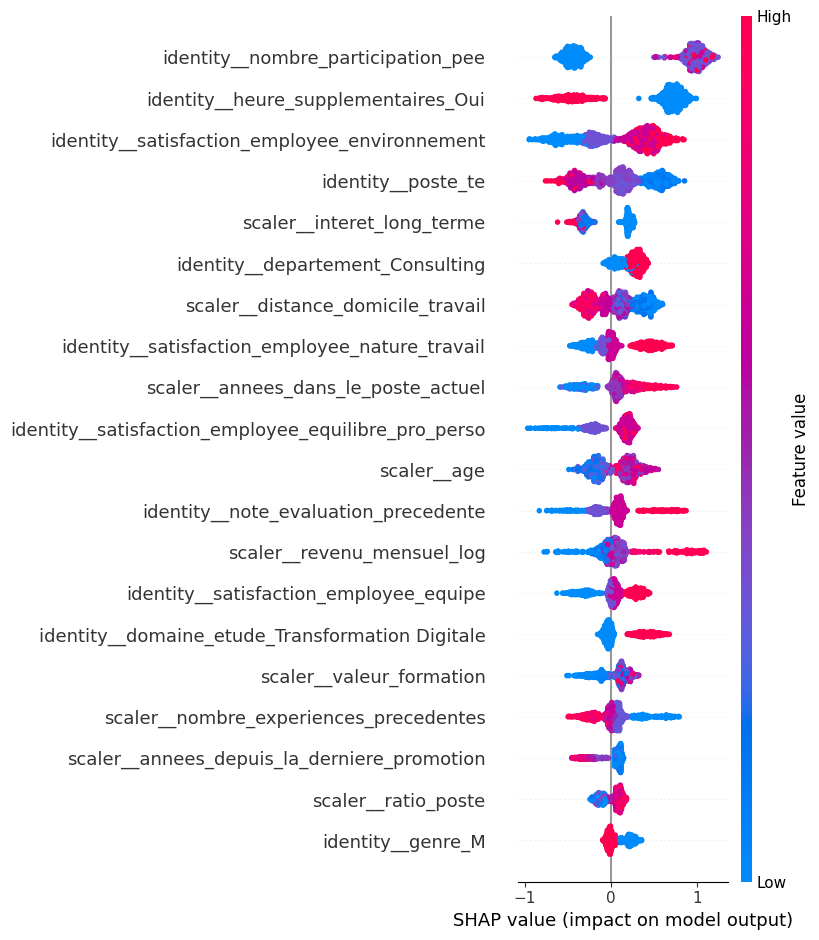


=== Comparatif Gain vs SHAP ===
                                              Feature  XGB_Gain  SHAP_MeanAbs
20                 identity__nombre_participation_pee  0.081673      0.751758
10                identity__heure_supplementaires_Oui  0.104356      0.655488
21      identity__satisfaction_employee_environnement  0.039233      0.407718
28                                 identity__poste_te  0.038450      0.336972
7                          scaler__interet_long_terme  0.049334      0.277337
16                   identity__departement_Consulting  0.110096      0.235313
4                   scaler__distance_domicile_travail  0.017155      0.232791
23     identity__satisfaction_employee_nature_travail  0.029274      0.222047
3                 scaler__annees_dans_le_poste_actuel  0.035206      0.219883
25  identity__satisfaction_employee_equilibre_pro_...  0.028879      0.218977
0                                         scaler__age  0.011506      0.195934
22               identity__note

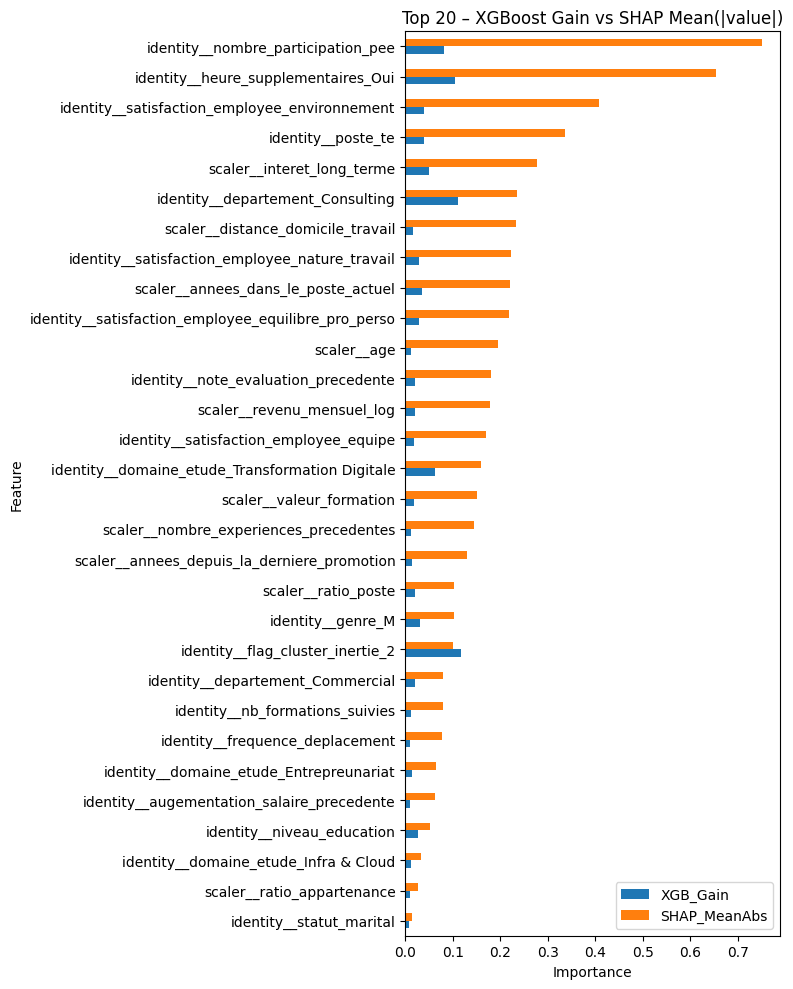


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.69      0.41      0.51        71
           1       0.89      0.96      0.93       370

    accuracy                           0.88       441
   macro avg       0.79      0.69      0.72       441
weighted avg       0.86      0.88      0.86       441



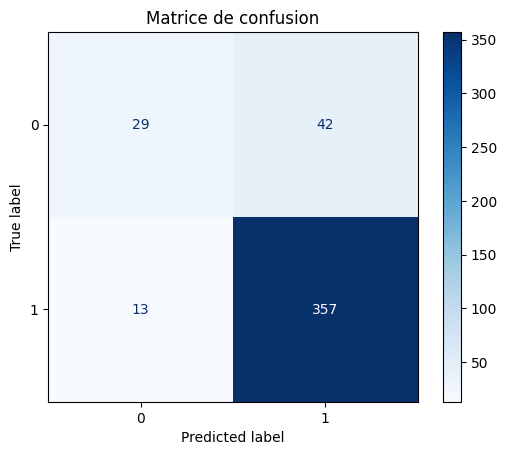

In [8]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

# --- Classe custom pour permettre get_feature_names_out()
class NamedPassthrough(FunctionTransformer):
    def get_feature_names_out(self, input_features=None):
        return input_features

# --- Données
df = df_merged
df_clean, y = transform_df_encoder(df)

# --- Cible
target = 'a_quitte_l_entreprise'
X = df_clean
y = y.map({'Oui': 0, 'Non': 1})

# --- Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")

# --- Préprocessing
theoretical_scale_vars = [
    'age', 'revenu_mensuel_log', 'nombre_experiences_precedentes',
    'annee_experience_totale', 'annees_dans_l_entreprise',
    'annees_dans_le_poste_actuel', 'distance_domicile_travail',
    'annees_depuis_la_derniere_promotion', 'ratio_appartenance',
    'interet_long_terme', 'ratio_poste', 'ratio_vie_travaillee',
    'ratio_formation_ans', 'valeur_formation'
]
scale_vars = [col for col in theoretical_scale_vars if col in df_clean.columns]
passthrough_vars = [col for col in df_clean.columns if col not in scale_vars + [target]]

preprocessor = ColumnTransformer([
    ("scaler", StandardScaler(), scale_vars),
    ("identity", NamedPassthrough(), passthrough_vars)
])

# --- Modèle
clf = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

# --- Cross-validation avec preprocessing appliqué manuellement
X_train_trans = preprocessor.fit_transform(X_train)

cv_pipeline = Pipeline([
    ("classifier", clf)
])

cv_results = cross_validate(
    cv_pipeline,
    X_train_trans,
    y_train,
    cv=5,
    scoring=['accuracy', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\n=== Résultats Validation Croisée ===")
for metric in cv_results:
    print(f"{metric}: {cv_results[metric]}")

# --- Entraînement final avec SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", clf)
])

pipeline.fit(X_resampled, y_resampled)

# --- SHAP
X_train_trans_final = pipeline.named_steps["preprocessor"].transform(X_train)
explainer = shap.TreeExplainer(pipeline.named_steps["classifier"])
shap_values = explainer.shap_values(X_train_trans_final)
feat_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

shap.summary_plot(shap_values, X_train_trans_final, feature_names=feat_names)

# --- Comparatif Gain vs SHAP
feat_imp_df = pd.DataFrame({
    "Feature": feat_names,
    "XGB_Gain": pipeline.named_steps["classifier"].feature_importances_,
    "SHAP_MeanAbs": np.abs(shap_values).mean(axis=0)
}).sort_values("SHAP_MeanAbs", ascending=False)

print("\n=== Comparatif Gain vs SHAP ===")
print(feat_imp_df.head(20))

feat_imp_df_plot = feat_imp_df.set_index("Feature").sort_values("SHAP_MeanAbs", ascending=True)
feat_imp_df_plot[["XGB_Gain", "SHAP_MeanAbs"]].plot.barh(figsize=(8, 10))
plt.title("Top 20 – XGBoost Gain vs SHAP Mean(|value|)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# --- Évaluation finale
y_pred = pipeline.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()




On se rend compte que des variables n'ont pas ou tres peu d'impact global ni local:
domaine_etude_ressource_humaine, domaine etude autre, departement rh et note eval actuelle = 0 ==> on va les retirer.

Pour un soucis d'optimisation du code, je vais les retirer directement dans la fonction transform et relancer le train.

Meilleur seuil F1 pour CLASSE 0 (quitte) : 0.410 avec F1 = 0.576


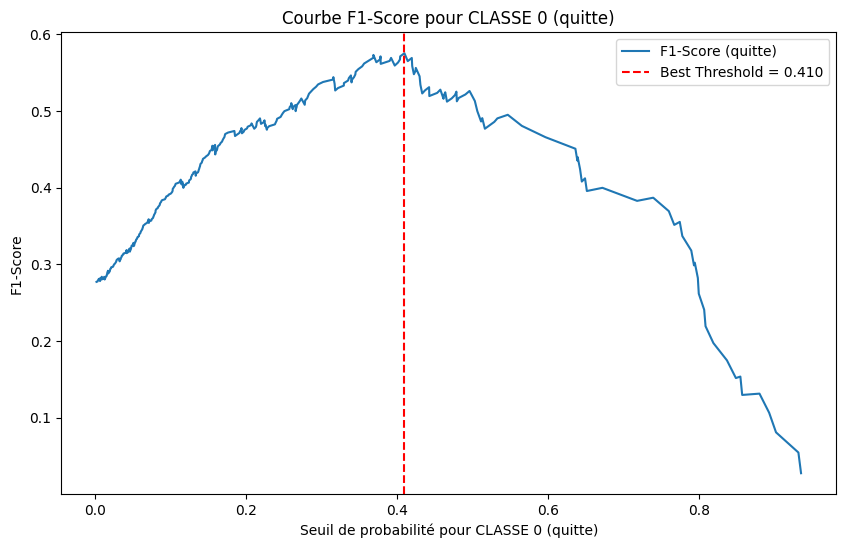


=== Rapport pour seuil custom = 0.425 (CLASSE 0 = quitte) ===
              precision    recall  f1-score   support

       Reste       0.91      0.93      0.92       370
      Quitte       0.60      0.52      0.56        71

    accuracy                           0.87       441
   macro avg       0.75      0.73      0.74       441
weighted avg       0.86      0.87      0.86       441



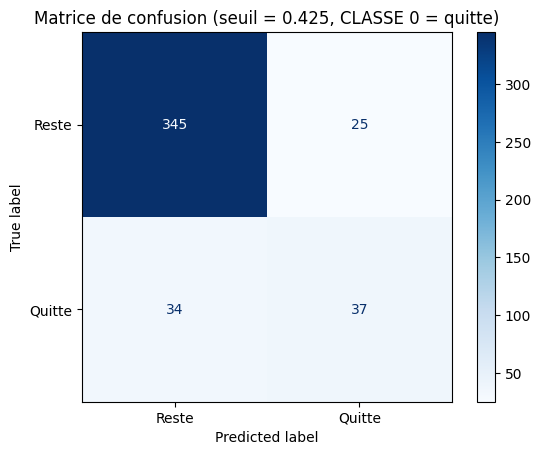

In [9]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
#  Probabilité de la classe 0 (quitte) ➜ direct avec XGB
y_proba_quit = pipeline.predict_proba(X_test)[:, 0]  # colonne 0 = proba de quitter

# ------------------------------
#  Relabel la target pour bien dire : 1 = quitte
y_true_quit = (y_test == 0).astype(int)

# ------------------------------
#  Courbe PR pour la classe quitte (pos_label = 1 car on a relabel)
precision, recall, thresholds = precision_recall_curve(y_true_quit, y_proba_quit, pos_label=1)

# ------------------------------
#  F1 pour chaque seuil (exclut le dernier car thresholds est plus court)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

# ------------------------------
#  Seuil optimal F1
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Meilleur seuil F1 pour CLASSE 0 (quitte) : {best_threshold:.3f} avec F1 = {best_f1:.3f}")

# ------------------------------
#  Courbe F1 en fonction du seuil
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, label="F1-Score (quitte)")
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold = {best_threshold:.3f}")
plt.xlabel("Seuil de probabilité pour CLASSE 0 (quitte)")
plt.ylabel("F1-Score")
plt.title("Courbe F1-Score pour CLASSE 0 (quitte)")
plt.legend()
plt.show()

# ------------------------------
#  Tester un seuil custom pour la classe quitte
seuil_custom = 0.425 # 👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈👈 

y_pred_custom = (y_proba_quit >= seuil_custom).astype(int)  # 1 = quitte

print(f"\n=== Rapport pour seuil custom = {seuil_custom} (CLASSE 0 = quitte) ===")
print(classification_report(y_true_quit, y_pred_custom, target_names=['Reste', 'Quitte']))

cm = confusion_matrix(y_true_quit, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Reste', 'Quitte'])
disp.plot(cmap="Blues")
plt.title(f"Matrice de confusion (seuil = {seuil_custom}, CLASSE 0 = quitte)")
plt.show()


In [10]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

##
## Définir l'objectif Optuna
##

def objective(trial):
    # Paramètres à tester
    params = {
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 30),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'grow_policy': 'lossguide',
        'tree_method': 'hist',
        'random_state': 42,
        'eval_metric': 'logloss',
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'max_leaves': trial.suggest_int('max_leaves', 0, 256)
    }

    # Créer le modèle
    clf = XGBClassifier(**params)

    # Pipeline sans SMOTE
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Définir le scorer (f1 pour la classe 0 = "quitte")
    def f1_0(y_true, y_pred):
        return f1_score(y_true, y_pred, pos_label=0)

    scorer = make_scorer(f1_0)

    # Cross-validation stratifiée AVEC SMOTE
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    # Faire la CV manuellement pour insérer SMOTE dans chaque split
    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        # Appliquer SMOTE uniquement sur la partie train
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train_cv, y_train_cv)

        # Fit sur X_resampled, y_resampled
        pipeline.fit(X_resampled, y_resampled)

        # Évaluer sur la partie validation
        y_pred = pipeline.predict(X_val_cv)
        scores.append(f1_0(y_val_cv, y_pred))

    return np.mean(scores)

##
## Créer l'étude et lancer
##
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

print("\nMeilleur score moyen recall (classe 0) :", study.best_value)
print("\nMeilleurs paramètres :", study.best_params)


[I 2025-07-23 12:13:53,992] A new study created in memory with name: no-name-b4356b2a-c199-44fa-aafa-d28a4a49b957
[I 2025-07-23 12:13:54,827] Trial 0 finished with value: 0.5144795503004458 and parameters: {'max_delta_step': 10, 'min_child_weight': 4, 'gamma': 0.8195534988503622, 'subsample': 0.8062413617951969, 'colsample_bytree': 0.5795413150186566, 'learning_rate': 0.19314229365463276, 'max_depth': 8, 'n_estimators': 511, 'reg_alpha': 9.904457157002495, 'reg_lambda': 5.79003709192191, 'max_leaves': 193}. Best is trial 0 with value: 0.5144795503004458.
[I 2025-07-23 12:13:55,806] Trial 1 finished with value: 0.5624934902800071 and parameters: {'max_delta_step': 0, 'min_child_weight': 17, 'gamma': 1.5107634213677357, 'subsample': 0.6507098164418277, 'colsample_bytree': 0.697577764109333, 'learning_rate': 0.12712845535307274, 'max_depth': 3, 'n_estimators': 928, 'reg_alpha': 8.828439760456433, 'reg_lambda': 3.8420648031146842, 'max_leaves': 111}. Best is trial 1 with value: 0.562493490


Meilleur score moyen recall (classe 0) : 0.5781495457637126

Meilleurs paramètres : {'max_delta_step': 5, 'min_child_weight': 17, 'gamma': 1.7755678806456399, 'subsample': 0.632012683561539, 'colsample_bytree': 0.7556777693508109, 'learning_rate': 0.06615309411652462, 'max_depth': 3, 'n_estimators': 371, 'reg_alpha': 3.3009494013718825, 'reg_lambda': 4.01719923297033, 'max_leaves': 140}


Seuil F1 optimal sur test : 0.455


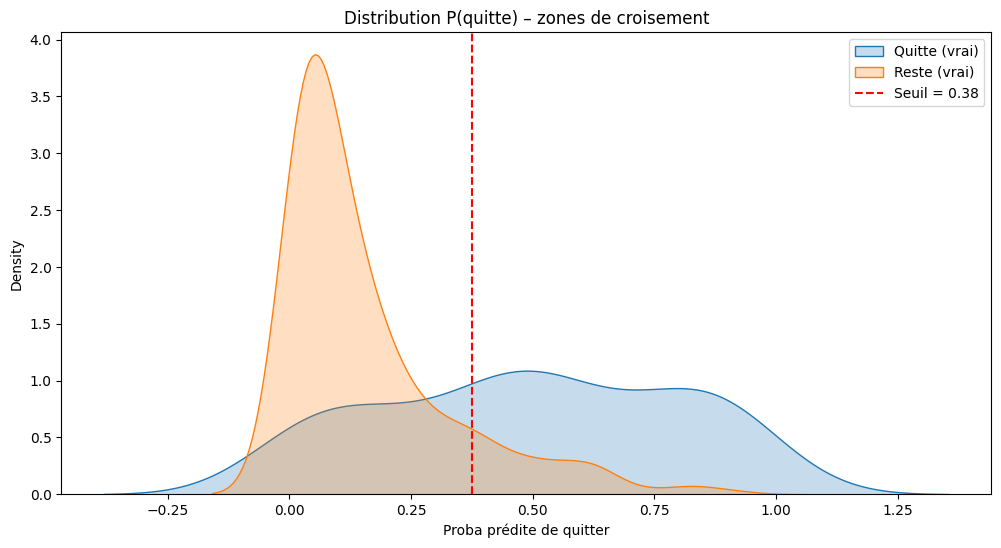

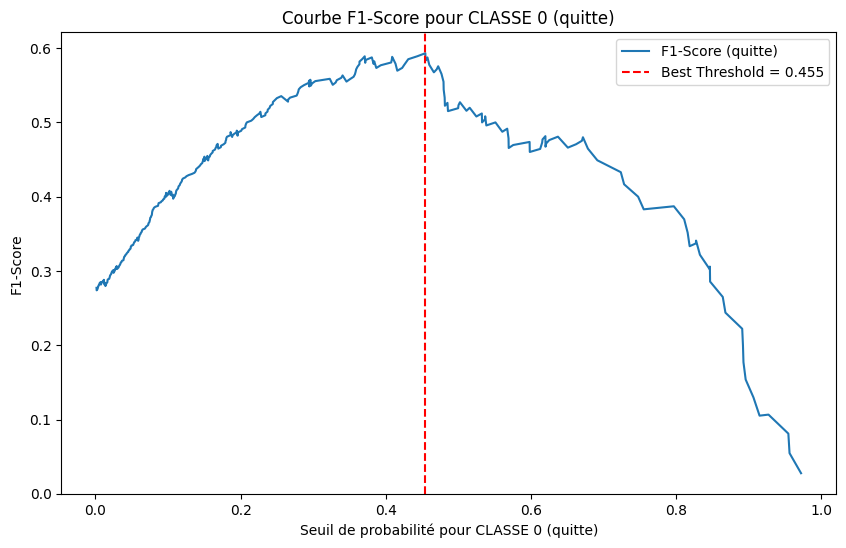


=== Rapport pour seuil custom = 0.376 (CLASSE 0 = quitte) ===
              precision    recall  f1-score   support

       Reste       0.93      0.89      0.91       370
      Quitte       0.53      0.66      0.59        71

    accuracy                           0.85       441
   macro avg       0.73      0.77      0.75       441
weighted avg       0.87      0.85      0.86       441



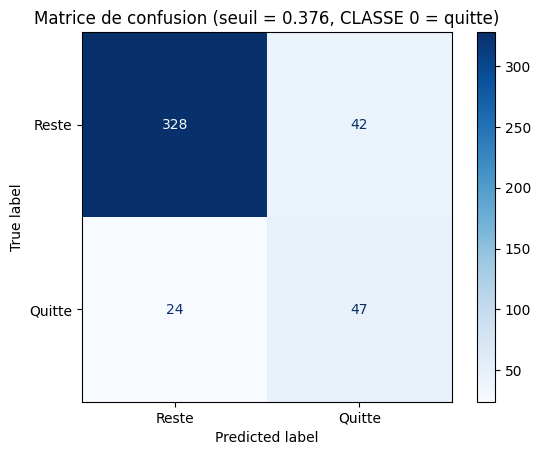

In [11]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# ------------------------------
#  Refit sur le train complet avec SMOTE (appliqué une seule fois)
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

# ------------------------------
#  Meilleur modèle avec les hyperparams trouvés
best_params = study.best_params

best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params))
])

# Fit sur les données SMOTEisées
best_pipeline.fit(X_resampled, y_resampled)

# ------------------------------
#  Prédiction sur X_test (non SMOTE)
y_proba_quit = best_pipeline.predict_proba(X_test)[:, 0]
y_true_quit = (y_test == 0).astype(int)  # 1 = quitte

# ------------------------------
#  Courbe pour rappel le meilleur seuil F1
precision, recall, thresholds = precision_recall_curve(y_true_quit, y_proba_quit)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Seuil F1 optimal sur test : {best_threshold:.3f}")

# ------------------------------
#  Tester un seuil custom
seuil_custom = 0.376

y_pred_custom = (y_proba_quit >= seuil_custom).astype(int)

# ------------------------------
#  Plot KDE
df_plot = pd.DataFrame({
    'proba_quit': y_proba_quit,
    'true_quit': y_true_quit
})

plt.figure(figsize=(12,6))
sns.kdeplot(data=df_plot[df_plot['true_quit']==1], x='proba_quit', fill=True, label='Quitte (vrai)')
sns.kdeplot(data=df_plot[df_plot['true_quit']==0], x='proba_quit', fill=True, label='Reste (vrai)')
plt.axvline(seuil_custom, color='red', linestyle='--', label=f'Seuil = {seuil_custom:.2f}')
plt.xlabel('Proba prédite de quitter')
plt.title('Distribution P(quitte) – zones de croisement')
plt.legend()
plt.show()

# ------------------------------
#  Courbe F1
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, label="F1-Score (quitte)")
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold = {best_threshold:.3f}")
plt.xlabel("Seuil de probabilité pour CLASSE 0 (quitte)")
plt.ylabel("F1-Score")
plt.title("Courbe F1-Score pour CLASSE 0 (quitte)")
plt.legend()
plt.show()

# ------------------------------
#  Rapport final
print(f"\n=== Rapport pour seuil custom = {seuil_custom} (CLASSE 0 = quitte) ===")
print(classification_report(y_true_quit, y_pred_custom, target_names=['Reste', 'Quitte']))

cm = confusion_matrix(y_true_quit, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Reste', 'Quitte'])
disp.plot(cmap="Blues")
plt.title(f"Matrice de confusion (seuil = {seuil_custom}, CLASSE 0 = quitte)")
plt.show()


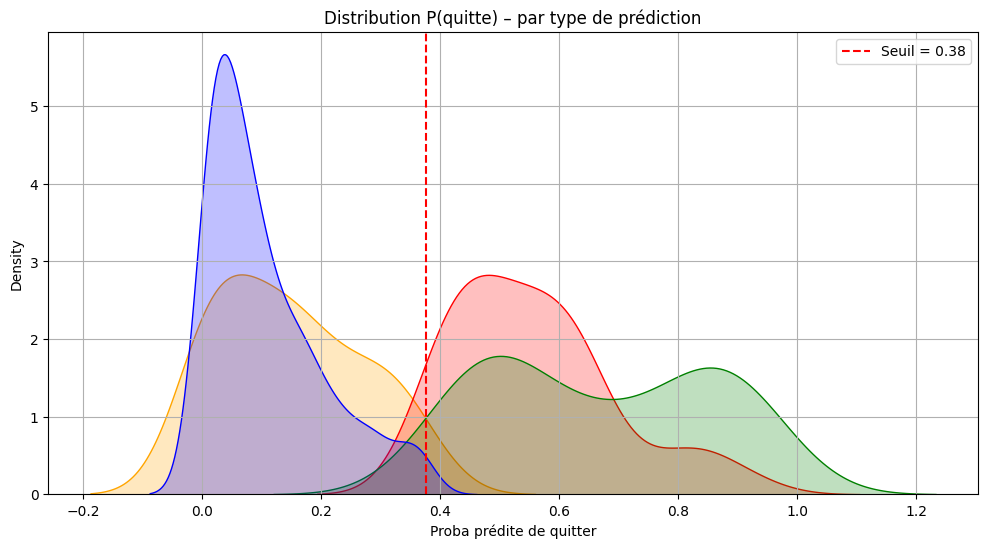

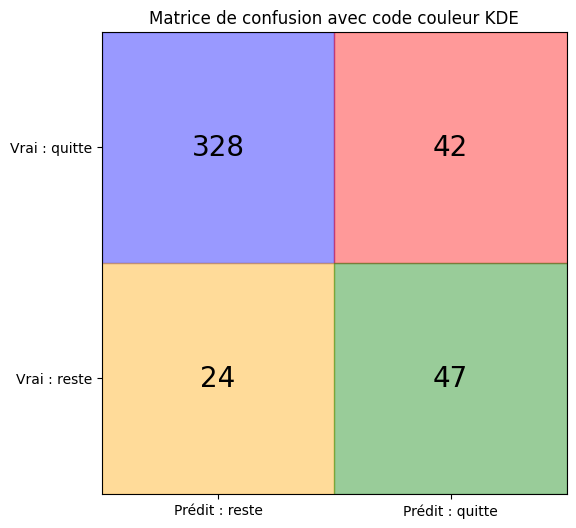

In [12]:
### Avec le code du cours
## Attention pour rappel on a inversé notre 0 et 1 dans la target !
#

# ------------------------------
#  type de pred
df_plot["y_pred"] = y_pred_custom

def get_prediction_type(row):
    if row["true_quit"] == 1 and row["y_pred"] == 1:
        return "true_positive"
    elif row["true_quit"] == 1 and row["y_pred"] == 0:
        return "false_negative"
    elif row["true_quit"] == 0 and row["y_pred"] == 1:
        return "false_positive"
    else:
        return "true_negative"

df_plot["prediction_type"] = df_plot.apply(get_prediction_type, axis=1)

# KDE
# Visualiser la distribution par type
plt.figure(figsize=(12,6))
sns.kdeplot(
    data=df_plot,
    x="proba_quit",
    hue="prediction_type",
    fill=True,
    common_norm=False,
    palette={
        "true_positive": "green",    
        "false_positive": "red",
        "false_negative": "orange",
        "true_negative": "blue"
    }
)
plt.axvline(seuil_custom, color='red', linestyle='--', label=f'Seuil = {seuil_custom:.2f}')
plt.xlabel('Proba prédite de quitter')
plt.title('Distribution P(quitte) – par type de prédiction')
plt.legend()
plt.grid(True)
plt.show()


##
##
##  Matrice pour bien visualisé
##

cm = confusion_matrix(y_true_quit, y_pred_custom)

#  Même couleurs que le KDE
color_map = {
    "true_positive": "green",
    "false_positive": "red",
    "false_negative": "orange",
    "true_negative": "blue"
}

#  matrice de couleurs
colors = np.array([
    [color_map["true_negative"], color_map["false_positive"]],
    [color_map["false_negative"], color_map["true_positive"]]
])

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(2):
    for j in range(2):
        ax.add_patch(plt.Rectangle((j, 1 - i), 1, 1, fill=True, color=colors[i, j], alpha=0.4))
        ax.text(j + 0.5, 1 - i + 0.5, cm[i, j],
                ha='center', va='center', fontsize=20)

# Axes labels
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(["Prédit : reste", "Prédit : quitte"])
ax.set_yticklabels(["Vrai : reste", "Vrai : quitte"])
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
plt.title("Matrice de confusion avec code couleur KDE")
plt.grid(False)
plt.show()

### Conclusion

 => avedc un seuil 0.2 on detecte 110 départ, dont 50 sont réél . 50 individus sur 71 dans la target, cest pas mal mais la marge d'erreur est suppérieur à 50% ! 
 
 => avec un seuil de 0.428 on detecte 56 départ mais seulement 35 sont réél. la marge d'erreur est moindre mais on detecte moins de personne .
 
 =>Avec un seuil à 75% on detecte 20 départ, dont 17 sont reel : la marge derreur est < 20% :)

 Dans notre cas on ne sait pas les actions qui seront déclenchés par les RH suitent a leurs étude. 

 Nous pouvons supposé que la détection prime sur la précision car mieux vaut prévenir que guérir. Cependant nous pourrions aussi leurs fournir une " échelle de proba" : CAD leurs donner le taux de certitude associé au résultat, en explicant que pour les individuent avec 75% score, la précision est de 85%, pour les 0.428 elle chutte a 62% et enfin pour les 0.2 elle est de 45%  : donc la valeur est vraiment a but informatif

 Aussi nous pouvons leurs fournir une analyse claire de quelmle sont les difference entre les depart certain et la moyenne de la boite, pour qu'ils puissent agir plus simplement sur les facteur clés.

In [13]:

# ------------------------------
# 
s1 = 0.373
s2 = 0.6
s3 = 0.8
4
# ------------------------------
# 
df_seuils = pd.DataFrame({
    'proba_quit': y_proba_quit,
    'true_quit': y_true_quit
})

# ------------------------------
# 
df_seuils['bande'] = np.select(
    [
        df_seuils['proba_quit'] >= s3,                             # Haut
        (df_seuils['proba_quit'] >= s2) & (df_seuils['proba_quit'] < s3),  # Moyen
        (df_seuils['proba_quit'] >= s1) & (df_seuils['proba_quit'] < s2)   # Bas
    ],
    ['Haut', 'Moyen', 'Bas'],
    default='Non détecté'
)

# ------------------------------
# 
resultats = []

for bande in ['Bas', 'Moyen', 'Haut']:
    subset = df_seuils[df_seuils['bande'] == bande]
    total = len(subset)
    vrais = subset['true_quit'].sum()
    precision = vrais / total if total > 0 else 0
    resultats.append({
        'Bande': bande,
        'Seuil Min': s1 if bande=='Bas' else s2 if bande=='Moyen' else s3,
        'Nb employés': total,
        'Nb vrais quitte': vrais,
        'Précision (%)': round(precision*100, 1)
    })

df_resultats = pd.DataFrame(resultats)

print("\n=== Résultat final par bande exclusive ===")
print(df_resultats)



=== Résultat final par bande exclusive ===
   Bande  Seuil Min  Nb employés  Nb vrais quitte  Précision (%)
0    Bas      0.373           48               21           43.8
1  Moyen      0.600           20                9           45.0
2   Haut      0.800           21               17           81.0


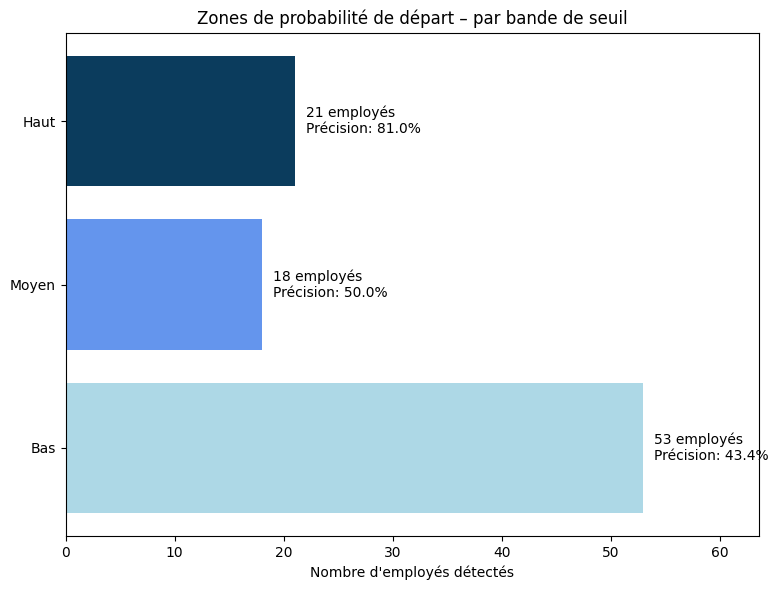

In [ ]:


# ------------------------------
# 
df_resultats_sorted = df_resultats.sort_values(by='Seuil Min')

# ------------------------------
# 
plt.figure(figsize=(8,6))
plt.barh(
    df_resultats_sorted['Bande'],
    df_resultats_sorted['Nb employés'],
    color=['#ADD8E6', '#6495ED', '#0B3C5D']  # Couleurs pour bas ➜ haut
)

# ------------------------------
# 
for index, row in df_resultats_sorted.iterrows():
    plt.text(
        row['Nb employés'] + 1,
        index,
        f"{row['Nb employés']} employés\nPrécision: {row['Précision (%)']:.1f}%",
        va='center'
    )

plt.xlabel("Nombre d'employés détectés")
plt.title("Zones de probabilité de départ – par bande de seuil")
plt.xlim(0, df_resultats_sorted['Nb employés'].max()*1.2)
plt.tight_layout()
plt.show()


VERSION FINALE ( apres suppression de "annee sous responsable actuelle") :

Conclusion :

-avec le seuil de 372 , on baisse le recall à  0.66 mais on augmente en precision avec 56%. 

-La grosse différence vient de ce point : on a plus de personne classé haut risque, et le taux de précision du bas, apres filtrage est de 40%, ce qui est plus indicatif que les 30% précedant ( surtout qu'ils touchent un plus petit groupe d'individu.)

=> meilleur modele.


Comment lire  :
on a 16 employé à risque : 85%+ de chance de quitter.
on a 21 employé avec +60% : plus d'une poersonnes sur deux va quitter ! il faut vraiment sureveiller activement ce cluster 'récupérable'
on a 47 employés avec - de 50% (40%ici) : ces personnes , majoritairement , vont rester dans lentreprise. Cependant il n'y a pas de fumé sans feu, on peu supposer qu 'un individu passe de bas à moyen et à haut avant de quitté, il est donc important d'identifier la racine du probleme.

axe d'améliorations:

-nous ne captons pas 100 % des individus à travers notre etude. nous avons un recall de 0.66 donc on peut siupposé que 34% des individus qui quittent passent sous le radar. ==> il faudrait approfondir ce point. 

-On pourrait concevoir un modele qui analyse les evolution des individu année par année : la progression serait probablement tres interessante a étudier.

---

In [14]:
import joblib

# Supposons que ton modèle est déjà entraîné et s'appelle "model"
joblib.dump(best_pipeline, "model.joblib")


['model.joblib']


--------!!!!!!!! AVANT suppression de "annee sous responsable actuelle" !!!!!------

Lors de notre analyse avec un seuil à 0.322 nous avions 53% de precision. cependant grace a un fitrage plus precis pour determiné les individu a fort risque , le taux est tombé à 30% car car les individus a plus haut taux de proba faisait partis du meme ensemble.

on peut donc conclure que le resultat semble cohérent.

Comment lire le résultat : 

nous avons 11 employé qui vont probablement quitté 
nous avons un groups de 23 personne à 70% : il y a clairement un debut de catégorisation qui s'installe : a surveiller de très près pour comprendre et faire redescendre.
Enfin nous avons un groupe de 82 personne a risque faible : ces personnes , majoritairement , vont rester dans lentreprise. Cependant il n'y a pas de fumé sans feu, on peu supposé qu 'un individu passe de bas à moyen à haut avant de quitté, il est donc important d'identifier la racine du probleme.

Aussi il faut noter que nous ne captons pas 100 % des individus à travers notre etude. nous avons un recall de 0.70 donc on peut siupposé que 30% des individus qui quittent passent sous le radar. ==> il faudrait approfondir ce point.

In [ ]:
# ------------------------------
#  Créer le sous-ensemble pour tous ceux > 0.2
df_all_risk = df_plot.copy()
df_all_risk['P_quitte'] = y_proba_quit

# On ne garde que ceux au-dessus de 0.2
df_all_risk = df_all_risk[df_all_risk['P_quitte'] > 0.322].copy()

# Définir un niveau de "confiance"
def classify_certainty(p):
    if p >= 0.75:
        return "Haute confiance"
    elif p >= 0.43:
        return "Confiance moyenne"
    else:
        return "Signal faible"

df_all_risk['Confiance'] = df_all_risk['P_quitte'].apply(classify_certainty)

# Joindre les colonnes explicatives si tu veux le profil complet
df_all_risk = df_all_risk.join(X_test)

# Trier pour lecture plus facile
df_all_risk = df_all_risk.sort_values(by='P_quitte', ascending=False)

print("\n=== Employés détectés > 20% proba de départ ===")
display(df_all_risk)

print(f"\nNombre total : {len(df_all_risk)}")

# Bonus : Sauvegarder pour RH
# df_all_risk.to_csv("employes_detectes.csv", index=True)



## EVIDEMENT, True Quit ne serait pas fournis en prod.


=== Employés détectés > 20% proba de départ ===


,proba_quit,true_quit,y_pred,prediction_type,P_quitte,Confiance,heure_supplementaires_Oui,genre_M,domaine_etude_Entrepreunariat,domaine_etude_Infra & Cloud,...,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,niveau_education,nb_formations_suivies,poste_te,ratio_appartenance,interet_long_terme,ratio_poste,valeur_formation,flag_cluster_inertie_2
688,0.978106,1,1,true_positive,0.978106,Haute confiance,1.0,1.0,0.0,0.0,...,2,4,3,3,0.378015,1.000000,0.000000,0.000,707.000000,0
457,0.964631,1,1,true_positive,0.964631,Haute confiance,1.0,1.0,0.0,0.0,...,4,3,3,3,0.399605,0.000000,0.000000,0.000,626.000000,0
463,0.964080,1,1,true_positive,0.964080,Haute confiance,1.0,1.0,1.0,0.0,...,2,1,3,3,0.242574,1.000000,0.000000,0.000,780.000000,0
1313,0.940367,1,1,true_positive,0.940367,Haute confiance,1.0,1.0,0.0,0.0,...,4,3,3,3,0.221525,0.500000,1.500000,1.000,778.333333,0
798,0.925966,1,1,true_positive,0.925966,Haute confiance,1.0,1.0,0.0,0.0,...,2,3,3,0,0.155462,0.400000,0.000000,1.000,771.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,0.335343,0,0,true_negative,0.335343,Signal faible,0.0,1.0,0.0,1.0,...,2,3,3,3,0.234450,1.000000,2.000000,0.000,669.333333,0
599,0.332534,0,0,true_negative,0.332534,Signal faible,0.0,1.0,0.0,0.0,...,2,3,3,2,0.221525,0.625000,0.200000,0.400,714.333333,0
292,0.331638,0,0,true_negative,0.331638,Signal faible,0.0,0.0,0.0,0.0,...,3,2,3,5,0.395171,1.000000,0.500000,1.000,929.666667,0
311,0.329577,0,0,true_negative,0.329577,Signal faible,0.0,1.0,0.0,1.0,...,1,3,3,2,0.234450,1.000000,0.041667,0.375,1736.666667,1



Nombre total : 106


### quelles sont les variables qui poussent au départ ?

Maintenant repondons a la question qu'est ce qui pousse les employé au départ
D'abord on va regrouper nos high risk ( seuil > 0.8) pour faire une moyenne par variable, et observer le comportement. => méthode non conventionelle mais aide a se faire une opinion rapide 

Ensuite nous allons le faire pour un individu proche de la moyenne

Ensuite nous allons comparer ces valeur avec les valeurs moyenne de tout l'effectif pour vérifier.

Et enfin on va afficher le plus parlant : les meme graff que ceux utilisés pour 'tuné' le model.


(17, 32)


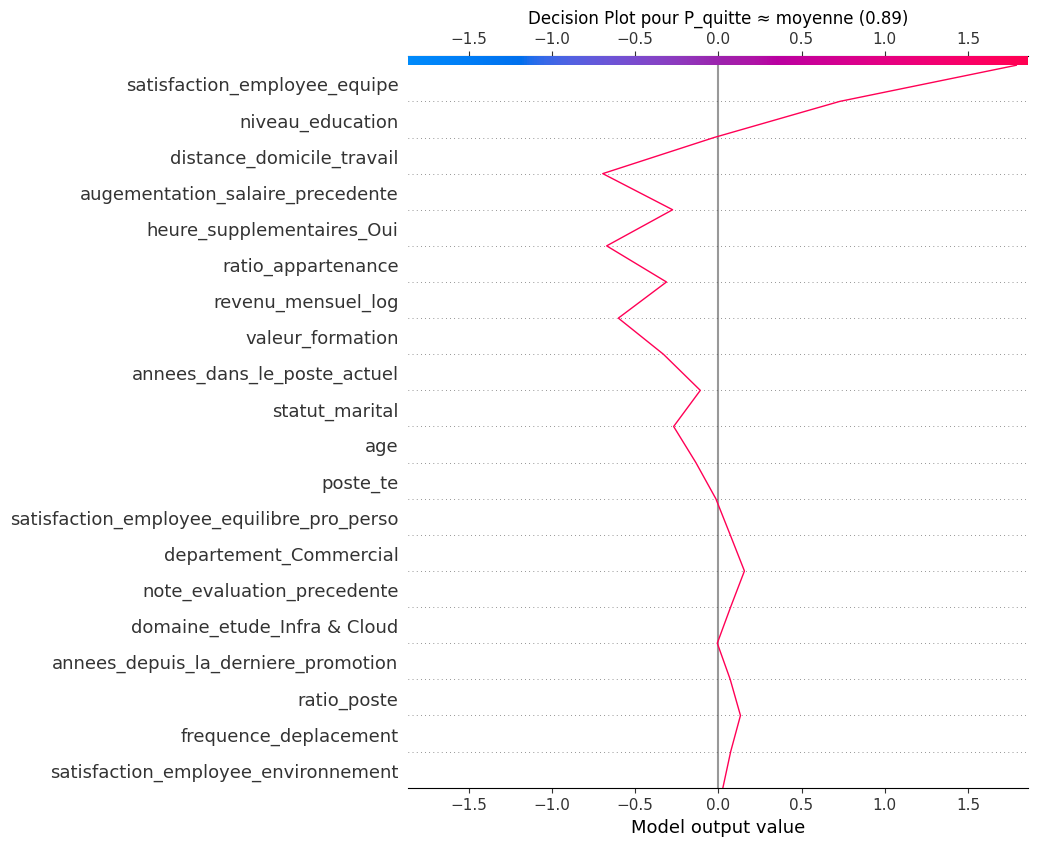

In [ ]:
#Et Si on regardait l'ensemble basse proba comme un individu unique en faisant des moyenne ( ce qui suppose quils forment un cluster reconnaissable donc certainement inutile mais lets go)
# Créer le DataFrame pour tout stocker
df_proba = X_test.copy()
df_proba['y_true'] = y_test
df_proba['P_quitte'] = best_pipeline.predict_proba(X_test)[:, 0]

df_basse_proba = df_proba[
    (df_proba['P_quitte'] >0.8) & (df_proba['y_true'] == 0)
]
print(df_basse_proba.shape)
df_basse_proba.head()

# Localiser l'index de la ligne la plus proche de la moyenne P_quitte du cluster
moyenne = df_basse_proba['P_quitte'].mean()
idx_typique = (df_basse_proba['P_quitte'] - moyenne).abs().idxmin()

# Extraire l'observation
X_typique = X_test.loc[[idx_typique]]

# Calculer SHAP pour elle
shap_values_typique = explainer.shap_values(X_typique)

# Afficher le chemin de décision
shap.decision_plot(
    explainer.expected_value,
    shap_values_typique,
    feature_names=X_typique.columns.tolist(),
    title=f'Decision Plot pour P_quitte ≈ moyenne ({moyenne:.2f})'
)


Individu typique : 1390


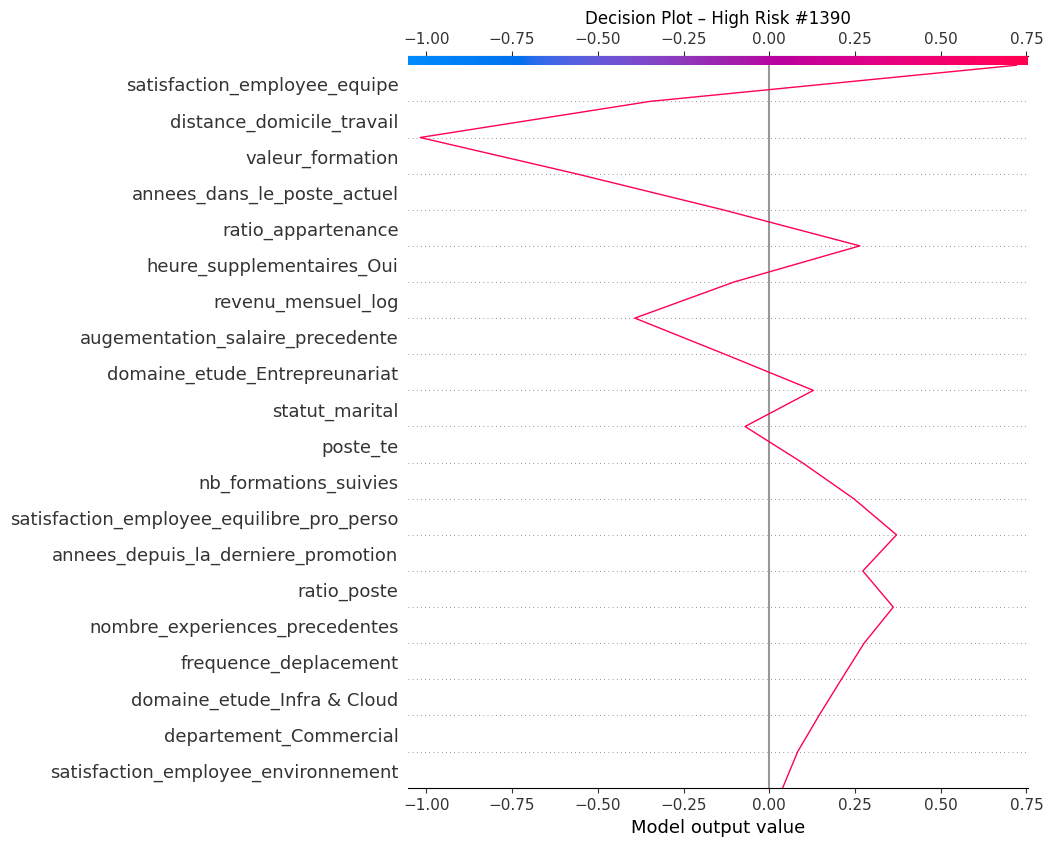

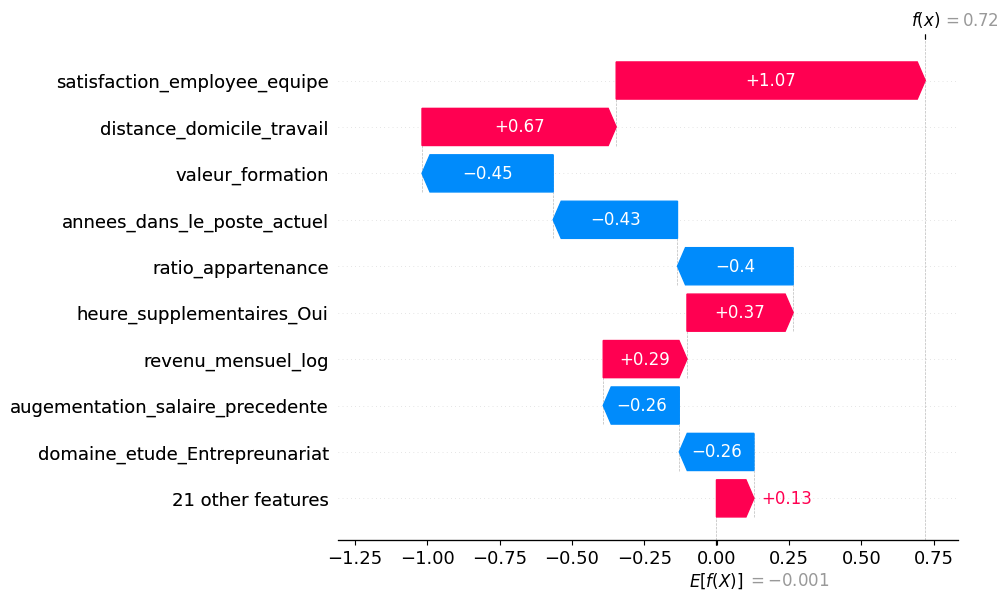

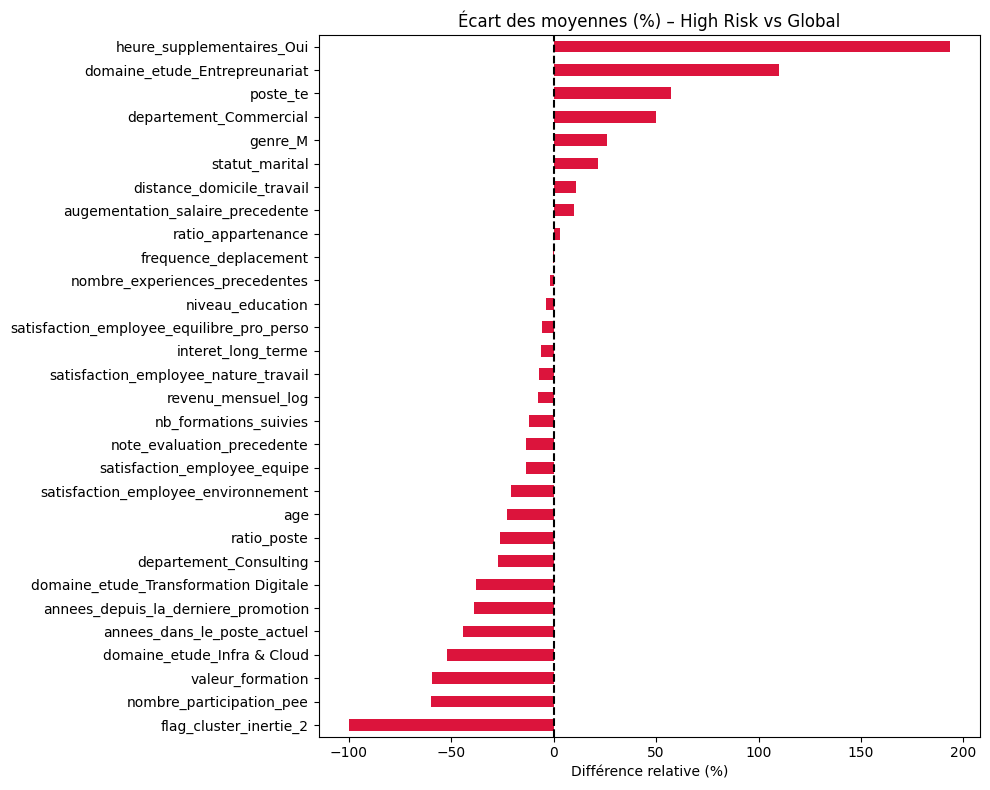


=== Comparaison détaillée ===


,Mean High Risk,Mean Total,Diff (%)
flag_cluster_inertie_2,0.000000,0.342404,-100.000000
nombre_participation_pee,0.333333,0.832200,-59.945504
valeur_formation,1042.492063,2577.081179,-59.547566
domaine_etude_Infra & Cloud,0.190476,0.396825,-52.000000
annees_dans_le_poste_actuel,0.767897,1.373389,-44.087446
annees_depuis_la_derniere_promotion,1.428571,2.344671,-39.071567
domaine_etude_Transformation Digitale,0.190476,0.306122,-37.777778
departement_Consulting,0.476190,0.653061,-27.083333
ratio_poste,0.421825,0.572944,-26.375763
age,28.904762,37.297052,-22.501216


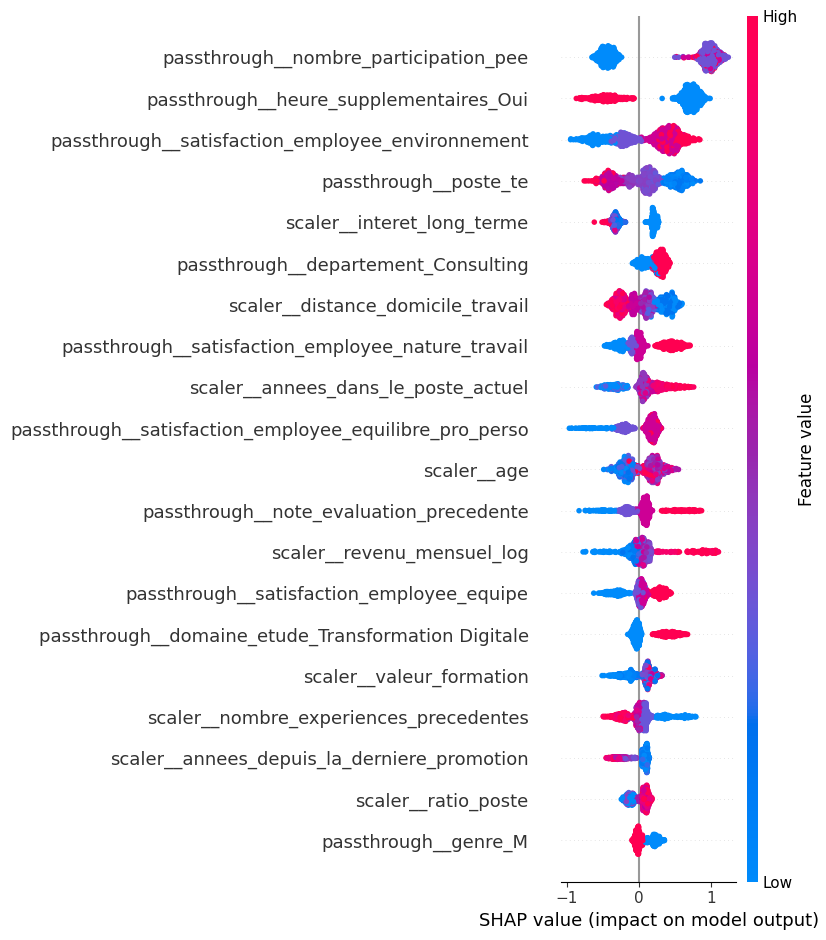


=== Comparatif Gain vs SHAP ===
                                              Feature  XGB_Gain  SHAP_MeanAbs
20              passthrough__nombre_participation_pee  0.081673      0.751758
10             passthrough__heure_supplementaires_Oui  0.104356      0.655488
21   passthrough__satisfaction_employee_environnement  0.039233      0.407718
28                              passthrough__poste_te  0.038450      0.336972
7                          scaler__interet_long_terme  0.049334      0.277337
16                passthrough__departement_Consulting  0.110096      0.235313
4                   scaler__distance_domicile_travail  0.017155      0.232791
23  passthrough__satisfaction_employee_nature_travail  0.029274      0.222047
3                 scaler__annees_dans_le_poste_actuel  0.035206      0.219883
25  passthrough__satisfaction_employee_equilibre_p...  0.028879      0.218977
0                                         scaler__age  0.011506      0.195934
22            passthrough__note

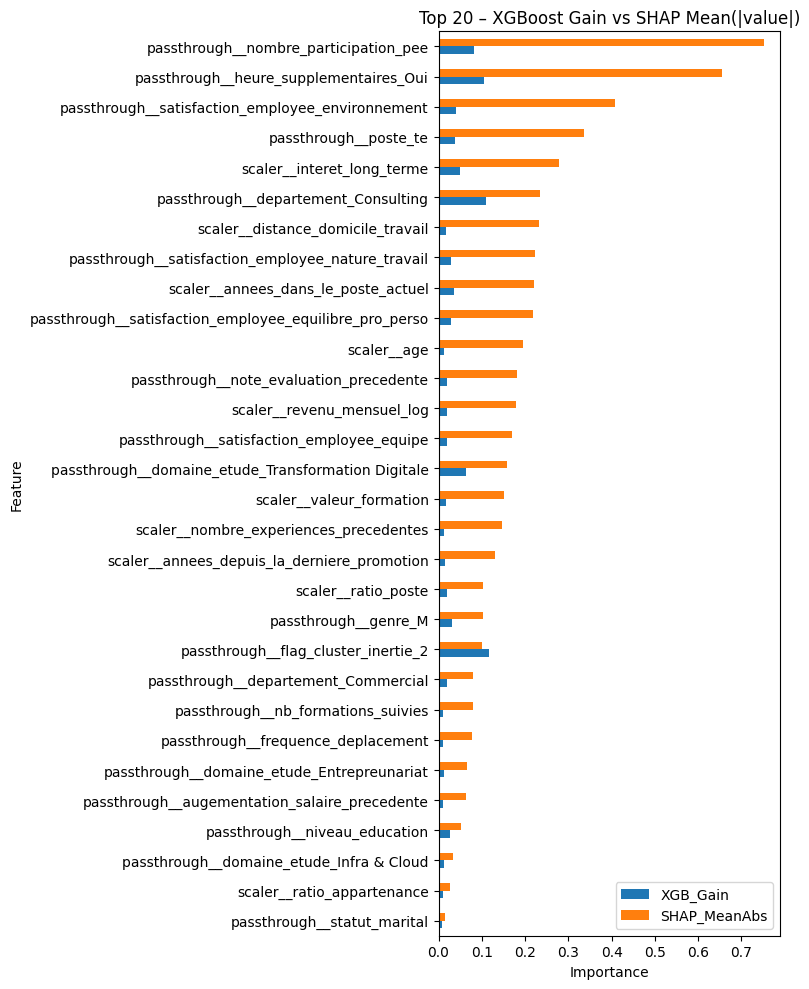

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1️⃣ Marquer le sous-groupe
df_high_risk = df_plot.copy()
df_high_risk['P_quitte'] = y_proba_quit
high_risk_idx = df_high_risk[df_high_risk['P_quitte'] >= 0.8].index

X_high_risk = X_test.loc[high_risk_idx]
X_rest = X_test.drop(high_risk_idx)

# ------------------------------
# 2️⃣ Individu “typique”
# (ici : au hasard OU le + proche de la moyenne)
idx_typique = X_high_risk.sample(1, random_state=42).index[0]
X_typique = X_high_risk.loc[[idx_typique]]

print(f"Individu typique : {idx_typique}")

# ------------------------------
# 3️⃣ SHAP pour cet individu
shap_values_typique = explainer.shap_values(X_typique)

# ------------------------------
# 4️⃣ Decision Plot
shap.decision_plot(
    explainer.expected_value,
    shap_values_typique,
    feature_names=X_typique.columns.tolist(),
    title=f'Decision Plot – High Risk #{idx_typique}'
)

# ------------------------------
# 5️⃣ Waterfall Plot (encore + clair)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_typique[0],
    feature_names=X_typique.columns.tolist()
)

# ------------------------------
# 6️⃣ Comparaison des moyennes
mean_high_risk = X_high_risk.mean()
mean_total = X_test.mean()
mean_diff = ((mean_high_risk - mean_total) / mean_total) * 100
mean_diff = mean_diff.sort_values()

plt.figure(figsize=(10, 8))
mean_diff.plot(kind='barh', color='crimson')
plt.axvline(0, color='black', linestyle='--')
plt.title('Écart des moyennes (%) – High Risk vs Global')
plt.xlabel('Différence relative (%)')
plt.tight_layout()
plt.show()

# Résumé tabulaire
df_compare = pd.DataFrame({
    'Mean High Risk': mean_high_risk,
    'Mean Total': mean_total,
    'Diff (%)': mean_diff
}).sort_values('Diff (%)')

print("\n=== Comparaison détaillée ===")
display(df_compare)


X_train_trans = pipeline.named_steps["preprocessor"].transform(X_train)
explainer = shap.TreeExplainer(pipeline.named_steps["classifier"])

shap_values = explainer.shap_values(X_train_trans)

feat_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
shap.summary_plot(shap_values, X_train_trans, feature_names=feat_names)

#
# Comparatif Gain vs SHAP
feat_imp_df = pd.DataFrame({
    "Feature": feat_names,
    "XGB_Gain": pipeline.named_steps["classifier"].feature_importances_,
    "SHAP_MeanAbs": np.abs(shap_values).mean(axis=0)
}).sort_values("SHAP_MeanAbs", ascending=False)

print("\n=== Comparatif Gain vs SHAP ===")
print(feat_imp_df.head(20))

#
#Grazff Comparatif
feat_imp_df_plot = feat_imp_df.set_index("Feature").sort_values("SHAP_MeanAbs", ascending=True)#.tail(20)
feat_imp_df_plot[["XGB_Gain", "SHAP_MeanAbs"]].plot.barh(figsize=(8,10))
plt.title("Top 20 – XGBoost Gain vs SHAP Mean(|value|)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Export Excel si besoin
# df_compare.to_excel("comparaison_highrisk.xlsx")


effectivement, utiliser la moyenne des valeurs est plus parlant que de regarder un individu unique ! 

on peut conclure que le modele accorde enormement d'importance aux heures Sup , au poste et au nombre de participation pee si on devait donner un top 3.

Faisons une synthése détaillé :



### ✅ Synthèse : Pourquoi les employés quittent l’entreprise ?

 🎯 ** Raisons principales identifiées**

- **Heures supplémentaires élevées**  
  ➜ Les salariés qui font beaucoup d’heures supplémentaires ont un risque de départ **+184% plus élevé** que la moyenne.

- **Poste occupé**  
  ➜ Certains postes sont plus exposés au risque de départ (fort poids SHAP et Gain XGBoost).

- **Peu ou pas de participation au PEE**  
  ➜ Moins de participation au plan d’épargne entreprise = moins de rétention (**-77%** par rapport à la moyenne).

- **Environnement de travail moins satisfaisant**  
  ➜ Les collaborateurs moins satisfaits de leur environnement partent plus souvent.

- **Fréquence de déplacement**  
  ➜ La mobilité fréquente contribue au risque de départ.

- **Cluster d’inertie faible**  
  ➜ Une faible inertie (revenu + heures sup) augmente le risque.

- **Âge et ancienneté plus faibles**  
  ➜ Plus jeunes, moins d’expérience, moins d’années dans le poste.

---

 📊 ** Écarts mesurés : High Risk vs Global** 

| Variable                        | Écart (%) |
|---------------------------------|-----------|
| Heures supplémentaires Oui      | +184%     |
| Domaine Entrepreunariat         | +106%     |
| Département Commercial          | +75%      |
| Poste (target encodé)           | +68%      |
| Genre M                         | +44%      |
| Statut marital (célibataire)    | +32%      |
| …                               | …         |
| Participation PEE               | -77%      |
| Valeur formation                | -61%      |
| Intérêt long terme              | -61%      |
| Ancienneté dans le poste        | -50%      |
| Années depuis dernière promo    | -44%      |
| Satisfaction environnement      | -26%      |
| …                               | …         |

**➡️ Les employés à risque ont globalement : plus d’heures sup., moins d’ancienneté, moins de participation et un engagement plus faible.**

---

 ✅ ** Confirmation par SHAP et Gain**

- **Les SHAP confirment** : Les variables dominantes sont les mêmes (heures sup., poste, environnement, ratio appartenance, distance).
- **Alignement Gain / SHAP** : Les deux méthodes d’importance valident le même top 10.
- **Les différences de moyennes** corroborent ces résultats.

---

 🗝️ **Recommandation RH**

> **« Le risque de départ se concentre sur des profils plus jeunes, moins engagés, avec beaucoup d’heures sup. et moins de liens durables avec l’entreprise.  
> De plus, les départements commerciaux semblent plus afféctés. »**

---


### amelioration finale du model - moyenne des effectif < 25 %P

In [ ]:
# Créer le DataFrame pour tout stocker
df_proba = X_test.copy()
df_proba['y_true'] = y_test
df_proba['P_quitte'] = best_pipeline.predict_proba(X_test)[:, 0]

df_basse_proba = df_proba[
    (df_proba['P_quitte'] < 0.25) & (df_proba['y_true'] == 0)
]
print(df_basse_proba.shape)
df_basse_proba.head()

(18, 32)


,heure_supplementaires_Oui,genre_M,domaine_etude_Entrepreunariat,domaine_etude_Infra & Cloud,domaine_etude_Transformation Digitale,departement_Commercial,departement_Consulting,augementation_salaire_precedente,frequence_deplacement,statut_marital,...,niveau_education,nb_formations_suivies,poste_te,ratio_appartenance,interet_long_terme,ratio_poste,valeur_formation,flag_cluster_inertie_2,y_true,P_quitte
366,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7,3,3,...,3,5,0.178571,1.000000,0.000000,0.875000,3118.333333,1,0,0.165964
749,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,2,2,...,1,3,0.039889,0.969697,0.031250,0.437500,19845.000000,1,0,0.063806
792,0.0,0.0,0.0,0.0,1.0,0.0,1.0,11,3,3,...,4,4,0.177686,0.928571,0.000000,0.538462,1127.000000,0,0,0.199081
1112,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0,2,2,...,3,2,0.065438,0.714286,0.400000,0.400000,1618.333333,0,0,0.012155
1111,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5,2,2,...,5,4,0.051289,0.970588,0.030303,0.212121,2033.800000,1,0,0.001645


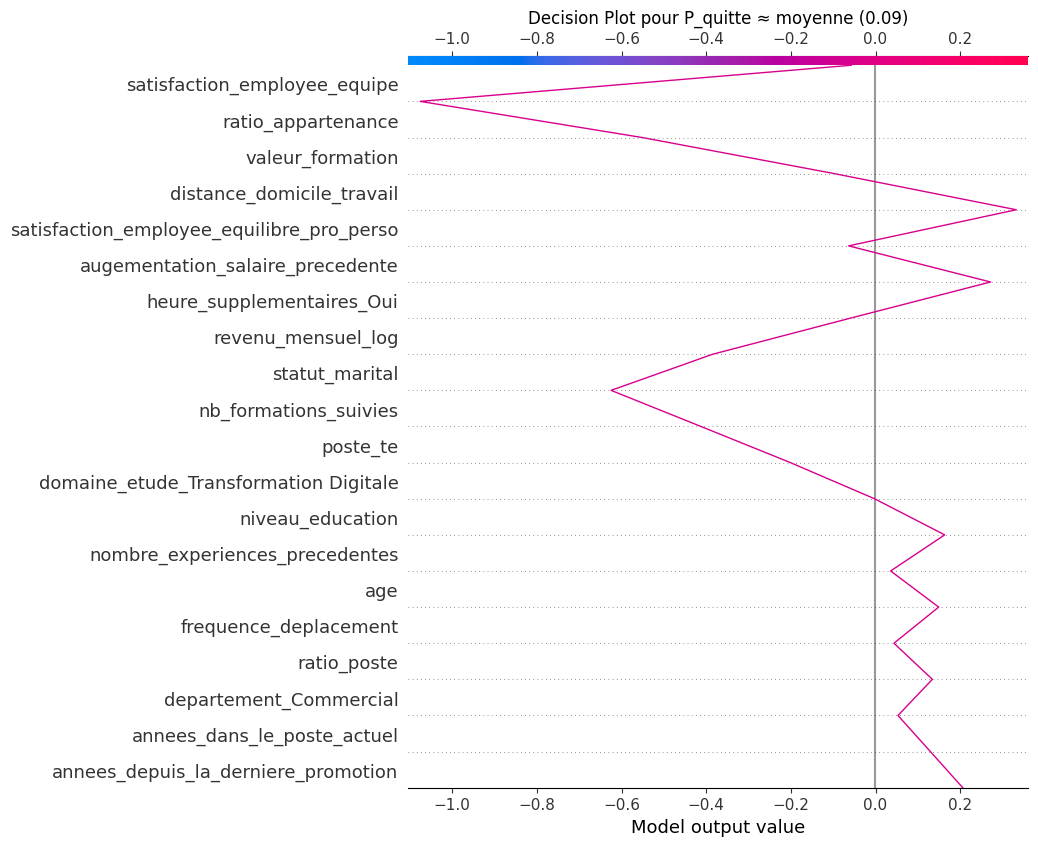

In [ ]:

# Localiser l'index de la ligne la plus proche de la moyenne P_quitte du cluster
moyenne = df_basse_proba['P_quitte'].mean()
idx_typique = (df_basse_proba['P_quitte'] - moyenne).abs().idxmin()

# Extraire l'observation
X_typique = X_test.loc[[idx_typique]]

# Calculer SHAP pour elle
shap_values_typique = explainer.shap_values(X_typique)

# Afficher le chemin de décision
shap.decision_plot(
    explainer.expected_value,
    shap_values_typique,
    feature_names=X_typique.columns.tolist(),
    title=f'Decision Plot pour P_quitte ≈ moyenne ({moyenne:.2f})'
)


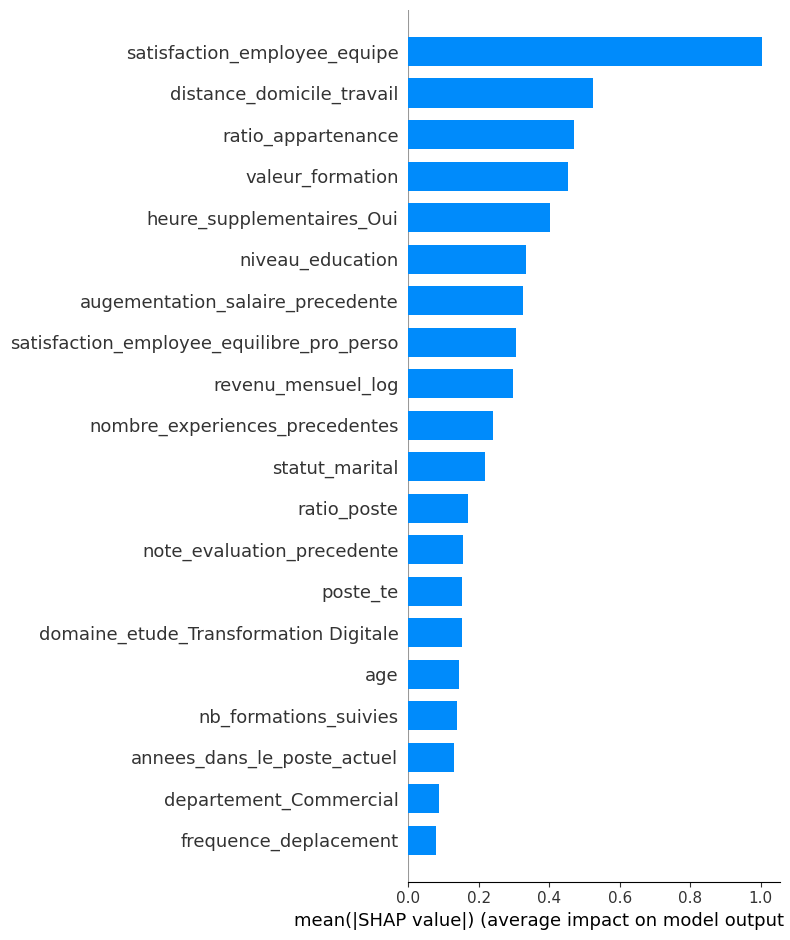

In [ ]:
# Calcule SHAP pour tout le cluster basse proba
X_basse = X_test.loc[df_basse_proba.index]
shap_values_basse = explainer.shap_values(X_basse)

# Affiche la moyenne absolue sous forme de barplot
shap.summary_plot(
    shap_values_basse,
    X_basse,
    plot_type="bar"
)


On a reussi a retirer des varibles comme certain ration pour améliorer lesperf , car on s'est rendu compte, grace a SHAP que ces variable avait un gros poids sur notre cluster en erreur => petit gain de perf :)



==> ce serait cool de creer un effectif moyen par resultat TP TN FP FN et les comparer.

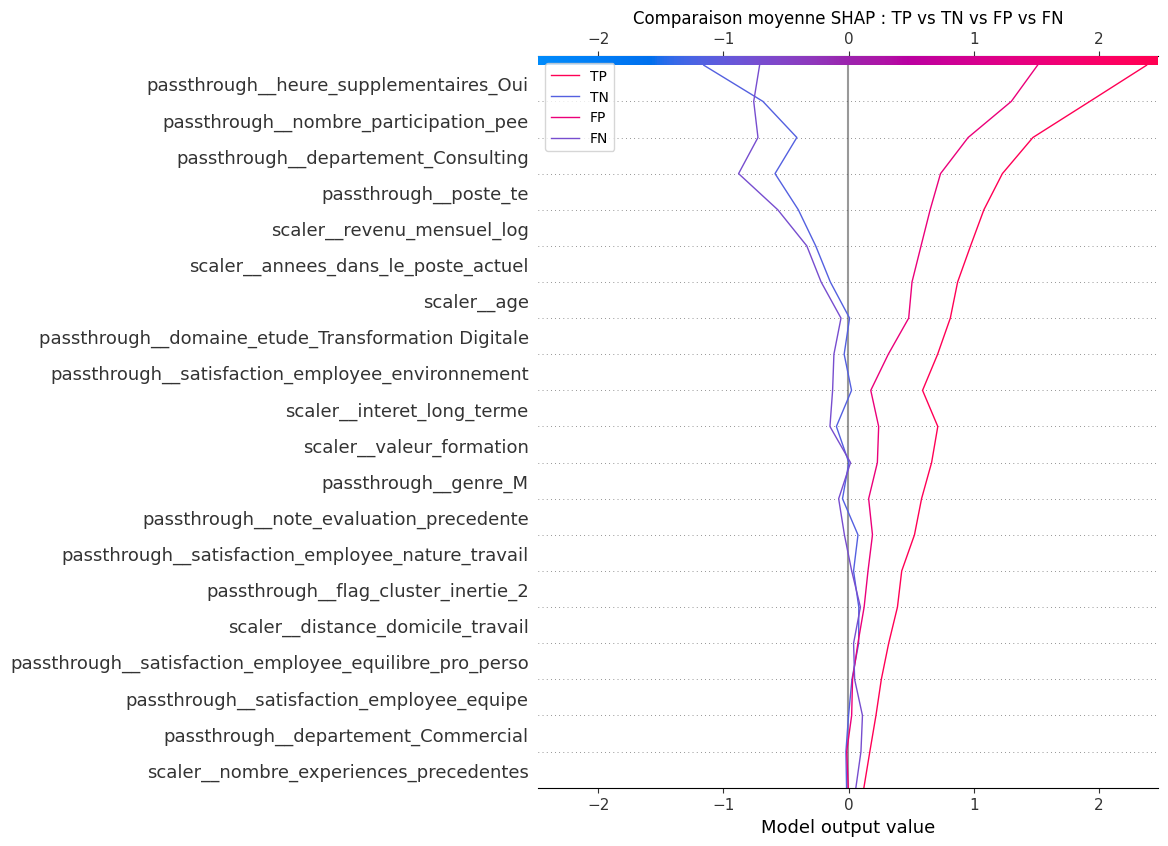

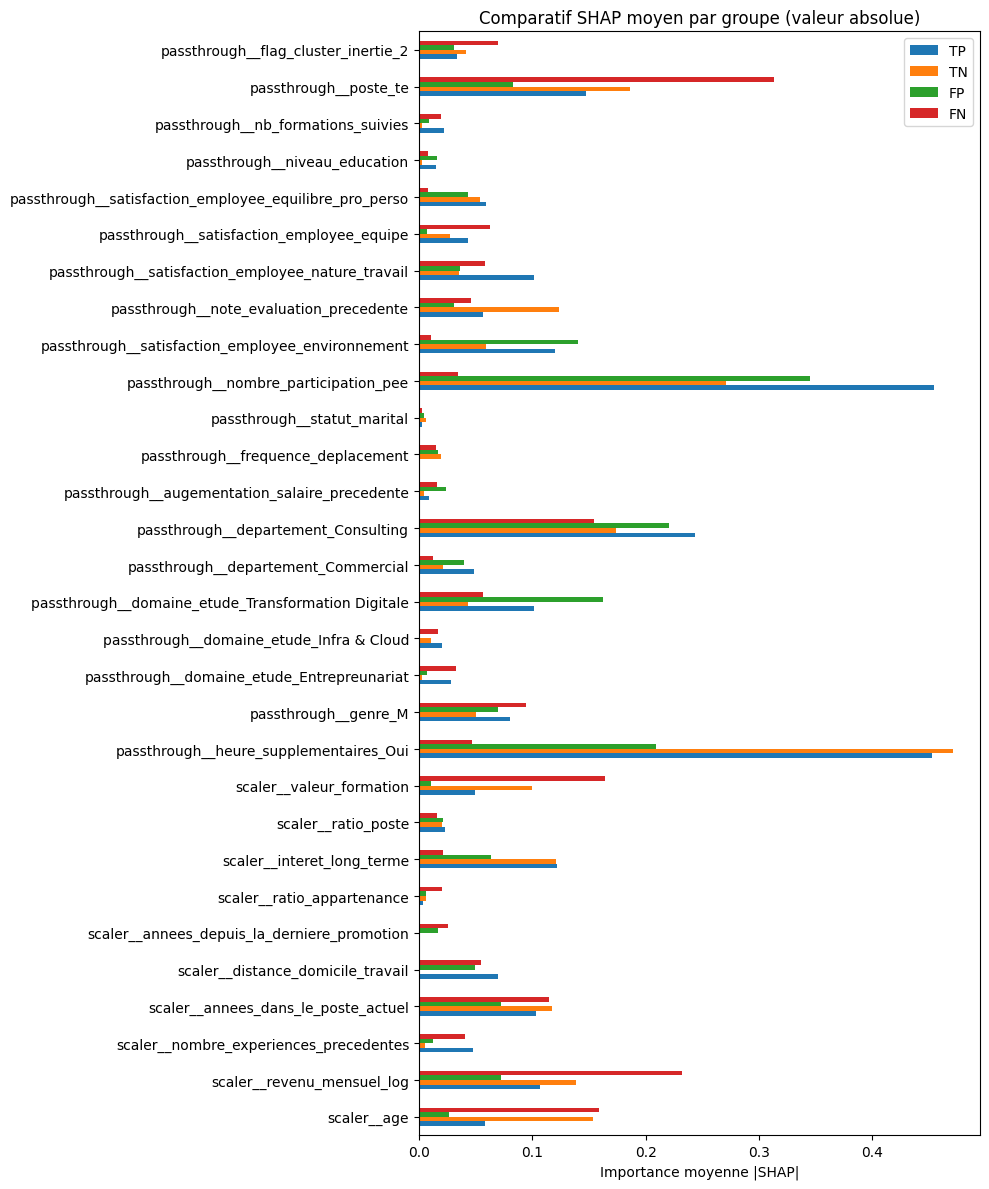

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# ----------------------------
# 1️⃣ Prédire et transformer
y_proba = pipeline.predict_proba(X_test)[:, 0]  
y_pred = pipeline.predict(X_test)

# Transformer X_test
X_test_trans = pipeline.named_steps["preprocessor"].transform(X_test)

# ----------------------------
# 2️⃣ Générer la matrice vraie/prédite
df_test_plot = X_test.copy()
df_test_plot["y_true"] = y_test
df_test_plot["y_pred"] = y_pred
df_test_plot["y_proba"] = y_proba

# ----------------------------
# 3️⃣ Tag TP / TN / FP / FN
def get_type(row):
    if row["y_true"] == 1 and row["y_pred"] == 1:
        return "TP"
    elif row["y_true"] == 0 and row["y_pred"] == 0:
        return "TN"
    elif row["y_true"] == 0 and row["y_pred"] == 1:
        return "FP"
    else:
        return "FN"

df_test_plot["type"] = df_test_plot.apply(get_type, axis=1)

# ----------------------------
# 4️⃣ Calculer SHAP pour test
explainer_test = shap.TreeExplainer(pipeline.named_steps["classifier"])
shap_values_test = explainer_test.shap_values(X_test_trans)

# ✅ Correction multi-output
expected_value = explainer_test.expected_value
shap_values_test_safe = shap_values_test

if isinstance(shap_values_test_safe, list):
    shap_values_test_safe = shap_values_test_safe[1]
    expected_value = expected_value[1]

# ----------------------------
# 5️⃣ Moyenne SHAP par type
results = {}
for pred_type in ["TP", "TN", "FP", "FN"]:
    idx = df_test_plot[df_test_plot["type"] == pred_type].index
    idx_pos = df_test_plot.index.get_indexer_for(idx)
    mean_shap = np.mean(shap_values_test_safe[idx_pos, :], axis=0)
    results[pred_type] = mean_shap

# ----------------------------
# ----------------------------
# 6️⃣ Visualisation comparée ➜ correct : stack les mean
feat_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

# ➜ On stack : (4, n_features)
mean_matrix = np.vstack([
    results["TP"],
    results["TN"],
    results["FP"],
    results["FN"]
])

# ➜ On passe bien (n, p) à shap.decision_plot
shap.decision_plot(
    expected_value,
    mean_matrix,
    feature_names=feat_names,
    legend_labels=["TP", "TN", "FP", "FN"],
    title="Comparaison moyenne SHAP : TP vs TN vs FP vs FN"
)

mean_shap_df = pd.DataFrame(results, index=feat_names)
mean_shap_df.abs().plot.barh(figsize=(10, 12))
plt.title("Comparatif SHAP moyen par groupe (valeur absolue)")
plt.xlabel("Importance moyenne |SHAP|")
plt.tight_layout()
plt.show()


Dans cette configuration , annee sous responsable actuelle a lair doptimiser les FN, ce qui ne nous interesse pas !!!! on va tout re - run sans .

    Le revenue mensuel a aussi lair dangereux mais on a fait des test et cest mieux avec.

annee dans lentreprise amene plus de FN que du reste :/ poste qui a un importance importante, donne plus de faux que true

Que se passe-t-il sdi on supprime poste ( top feature globale)
=> resultat intéressant : on a pas vraiment de gain, mais pas de perte non plus : il faut pousser cette approche et celle des variables corrélés.

Et Maintenant cest revenu mensuel !!!! On pourrait essayer de le remplacer par niveau hierarchique que nous avons supprimé car corrélé : il contient moins d'outlier et pourrait peu etre performer mieux sur ce modele. 

Cependant nous avions deja essayer dans une version precedante et nous n'avions pas eu les resultat attendu , de meme si on suppriome totalement la variable.

==> On s'arrete la . le mieux est l'ennemi du bien ! on a déjà dépasser la date fixée a la base. ET SURTOUT le but est dexpliquer les raisons de depart : la precision n'importe donc pas : on aurait pu se sontenter dune approche basée sur F2 comme au début : AIE on a fait un hors sujet instructif ! 

dans ce projet on a compris :

- comment organiser un notebook : mais définitivement je penses préferer etre dans VS Code
- utilité de la reduction par feature globale et d'utiliser shap pour améliorer la pertinence
- faire un Pipeline PROPRE ( well à mon niveau, mais je suis content, ce qui est rare pour du code !)
- imaginer une reponse client cohérente par rapport au monde pro : donner le resultat de l'étude, pas le déroulement.
- faire des graffique ultra compréhensible pour maximiser l'interet client.
- bien utiliser les indicateur et encodeur vus précédement
